In [4]:
import polars as pl
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


from itertools import groupby, dropwhile, filterfalse, starmap
from more_itertools import unzip

from jump_portrait.fetch import get_jump_image
from jump_portrait.utils import batch_processing, parallel

from collections.abc import Callable, Iterable
from typing import List
import cupy as cp

In [129]:
metadata = pl.read_csv("target2_eq_moa2_metadata")

In [130]:
#site: 1-9 str
#channel: ER, AGP, Mito, DNA and RNA

Few remarks on Jump_portrait

* In get_jump_image
    - Would be better if instead of broadcasting the error: "More than one site found", a suggestion of correction was given
    - Would be great to enable to pass a list of str instead of just a str. 

* all the parameters of get_jump_image are not ully explained:
    - example ```apply_correction``` vs ```apply_illum```
    - ```compressed```
    - ```staging```
* tqdm takes a lot of space: let's try something from [here](https://stackoverflow.com/questions/41707229/why-is-tqdm-printing-to-a-newline-instead-of-updating-the-same-line), or add a way to disable it. 

In [131]:
def try_function(f: Callable):
    '''
    Wrap a function into an instance which will Try to call the function:
        If it success, return a tuple of function parameters + its results
        If it fails, return the function parameters
    '''
    # This assume parameters are packed in a tuple
    def batched_fn(*item, **kwargs):
        try:
            result = (*item, f(*item, **kwargs))
            
        except:
            result = item

        return result    
    return batched_fn

In [132]:
def get_jump_image_iter(metadata: pl.DataFrame, channel: List[str], 
                        site:List[str], correction:str=None) -> (pl.DataFrame, List[tuple]): 
    '''
       Load jump image associated to metadata in a threaded fashion.
        ----------
    Parameters: 
        metadata(pl.DataFrame): must have the shape (Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well")
        channel(List[str]): list of channel desired
            Must be in ['DNA', 'ER', 'AGP', 'Mito', 'RNA']
        site(List[str]): list of site desired
            For compound, must be in ['1' - '6']
            For ORF, CRISPR, must be in ['1' - '9']
        correction(str): Must be 'Illum' or None
        ----------
    Return:
        features(pl.DataFrame): DataFrame collecting the metadata, channel, site, correction + the image
        work_fail(List(tuple): List collecting tuple of metadata which failed to load an image
        
    '''
    iterable = [(*metadata.row(i), ch, s, correction)
               for i in range(metadata.shape[0]) for s in site for ch in channel]
    img_list = parallel(iterable, batch_processing(try_function(get_jump_image)))
    
    img_list = sorted(img_list, key=lambda x: len(x))
    fail_success = {k: list(g) for k, g in groupby(img_list, key=lambda x: len(x))}
    if len(fail_success) == 1:
        img_success = list(fail_success.values())[0]
        work_fail = []
    else: 
        work_fail, img_success = fail_success.values()
    features = pl.DataFrame(img_success, 
                               schema=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well",
                                        "channel", "site", "correction",
                                        "img"])
    return features, work_fail

In [ ]:
features, work_fail = get_jump_image_iter(metadata.select(pl.col(["Metadata_Source", "Metadata_Batch", 
                                                                               "Metadata_Plate", "Metadata_Well"])),
                                                        channel=['DNA']#, 'ER', 'AGP', 'Mito', 'RNA'],
                                                        site=[str(i) for i in range(1, 7)],
                                                        correction="Illum")


In [122]:
source_fail, batch_fail, plate_fail, well_fail, *rest = map(lambda x: list(set(x)), list(unzip(work_fail)))

metadata = metadata.filter((pl.col("Metadata_Source").is_in(source_fail)&
                pl.col("Metadata_Batch").is_in(batch_fail)&
                pl.col("Metadata_Plate").is_in(plate_fail)&
                pl.col("Metadata_Well").is_in(well_fail)) != True)

In [127]:
features.shape

(23240, 8)

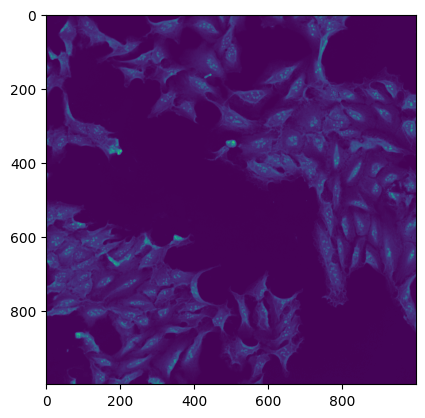

In [125]:
plt.imshow(features["img"][4])